# Hourly Time Series Forecasting using Facebook's Prophet

In this notebook we will use facebook's prophet package to forecast hourly energy use. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use( 'fivethirtyeight' )

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

In [2]:
pjme = pd.read_csv('./Data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

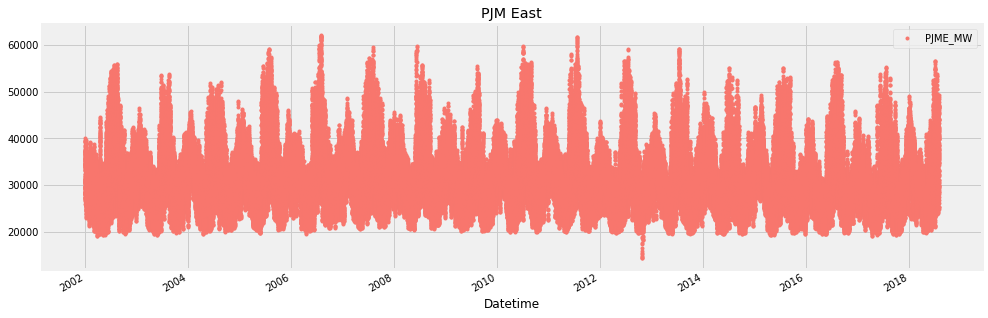

In [3]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

# EDA

We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [4]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

In [5]:
features_and_target.head(31)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0
2002-12-31 06:00:00,6,1,4,12,2002,365,31,1,26222.0
2002-12-31 07:00:00,7,1,4,12,2002,365,31,1,28702.0
2002-12-31 08:00:00,8,1,4,12,2002,365,31,1,30698.0
2002-12-31 09:00:00,9,1,4,12,2002,365,31,1,31800.0


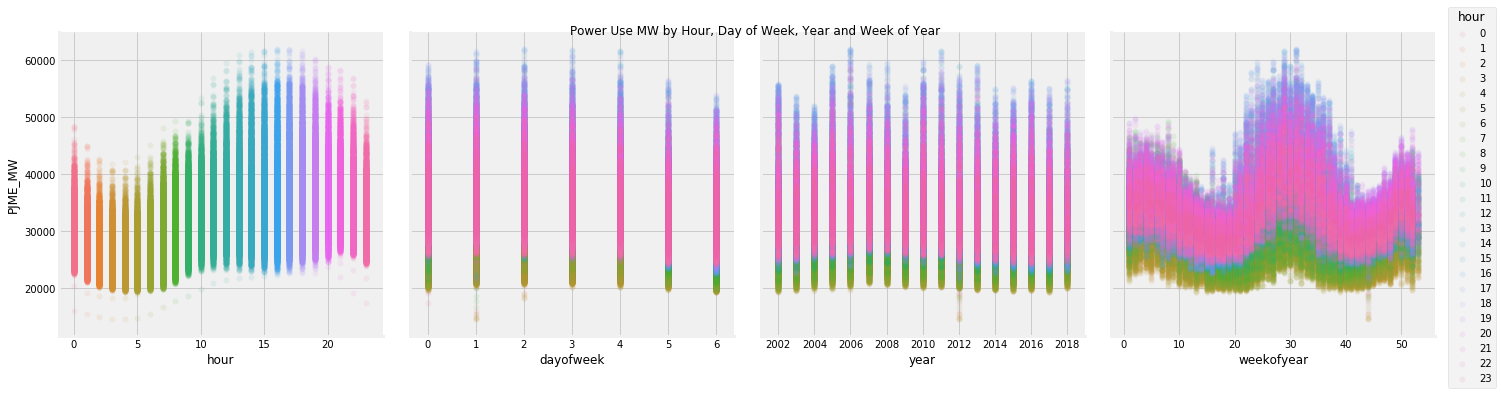

In [6]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek','year','weekofyear'],
             y_vars='PJME_MW',
             size=5,
             plot_kws={'alpha':0.1, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [18]:
split_date_trstart = '01-Jan-2014'
split_date_trend = '31-Dec-2014'
split_date_testart = '01-Jan-2015'
split_date_teend = '31-Dec-2015'
pjme_train = pjme.loc[( pjme.index >= split_date_trstart ) & ( pjme.index <= split_date_trend )].copy()
pjme_test = pjme.loc[( pjme.index >= split_date_testart ) & ( pjme.index <= split_date_teend )].copy()

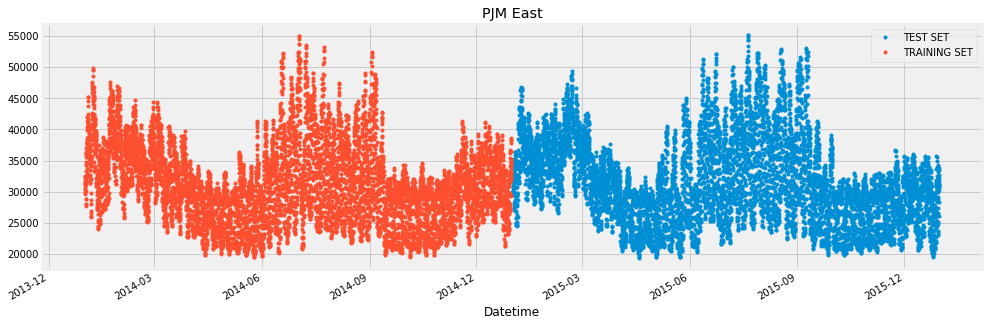

In [19]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

# Simple Prophet Model

In [25]:
# Format data for prophet model using ds and y
pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}).head(10)

,ds,y
0,2014-01-01 00:00:00,32595.0
1,2014-12-30 01:00:00,28113.0
2,2014-12-30 02:00:00,27215.0
3,2014-12-30 03:00:00,26899.0
4,2014-12-30 04:00:00,26889.0
5,2014-12-30 05:00:00,27605.0
6,2014-12-30 06:00:00,29394.0
7,2014-12-30 07:00:00,32092.0
8,2014-12-30 08:00:00,33954.0
9,2014-12-30 09:00:00,34728.0


In [23]:
# Setup and train model
model = Prophet( yearly_seasonality=20 )
model.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [24]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index().rename(columns={'Datetime':'ds'}))

In [26]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,31282.185029,29462.438070,37227.643375,31282.185029,31282.185029,2084.304684,2084.304684,2084.304684,-2244.591342,...,1531.663778,1531.663778,1531.663778,2797.232248,2797.232248,2797.232248,0.0,0.0,0.0,33366.489713
1,2015-01-01 01:00:00,31282.135977,27705.538708,35333.165212,31282.135977,31282.135977,272.793836,272.793836,272.793836,-4074.038392,...,1502.283626,1502.283626,1502.283626,2844.548601,2844.548601,2844.548601,0.0,0.0,0.0,31554.929813
2,2015-01-01 02:00:00,31282.086924,26267.761382,33784.041271,31282.086924,31282.086924,-1072.119199,-1072.119199,-1072.119199,-5435.960313,...,1472.103687,1472.103687,1472.103687,2891.737427,2891.737427,2891.737427,0.0,0.0,0.0,30209.967726
3,2015-01-01 03:00:00,31282.037872,25507.833656,33351.776972,31282.037872,31282.037872,-1834.659490,-1834.659490,-1834.659490,-6214.724280,...,1441.272358,1441.272358,1441.272358,2938.792431,2938.792431,2938.792431,0.0,0.0,0.0,29447.378382
4,2015-01-01 04:00:00,31281.988820,26079.815312,33153.109980,31281.988820,31281.988820,-1889.381895,-1889.381895,-1889.381895,-6285.030540,...,1409.941308,1409.941308,1409.941308,2985.707337,2985.707337,2985.707337,0.0,0.0,0.0,29392.606925


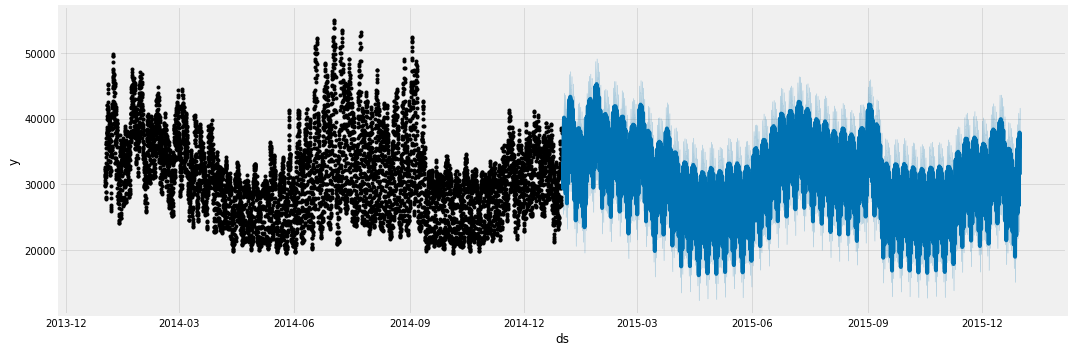

In [27]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst, ax=ax)

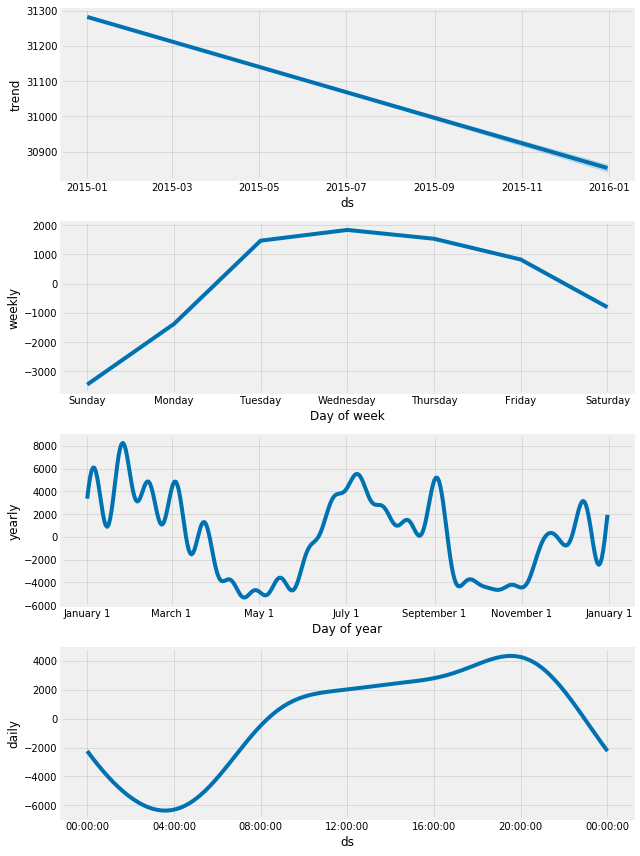

In [29]:
# Plot the components
fig = model.plot_components(pjme_test_fcst)

# Compare Forecast to Actuals

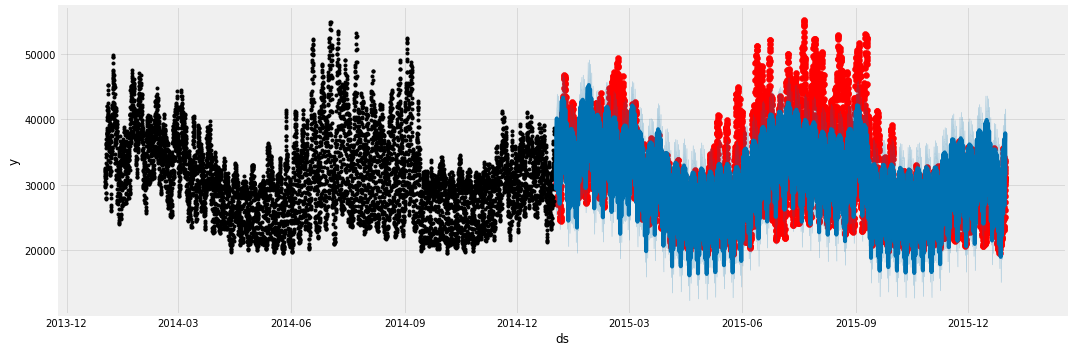

In [30]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)


# Look at first month of predictions

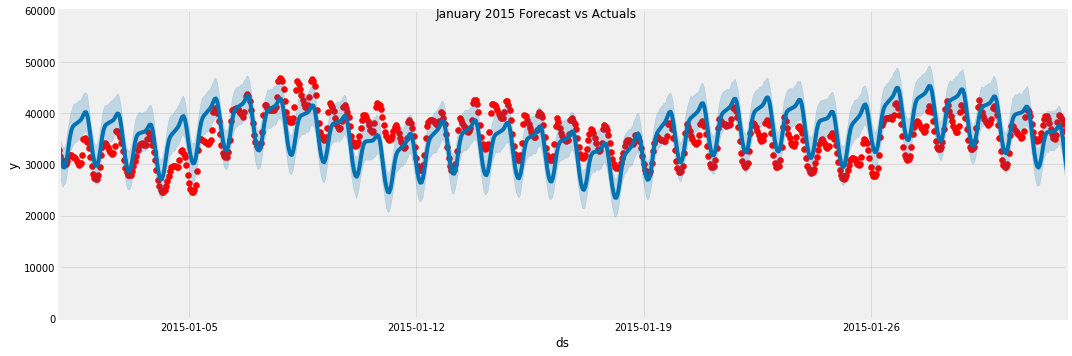

In [31]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

# Single Week of Predictions

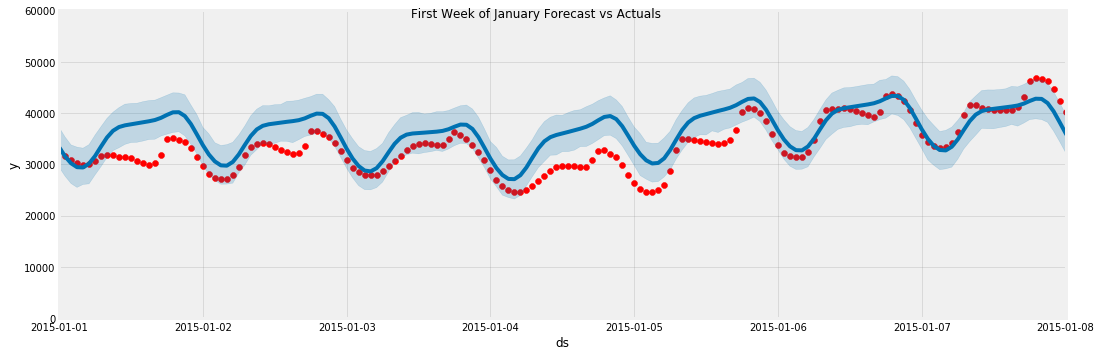

In [32]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

# Error Metrics

Our RMSE error is 43761675  
Our MAE error is 5181.78  
Our MAPE error is 16.5%

by comparison in the XGBoost model our errors were significantly less (8.9% MAPE):
[Check that out here](https://www.kaggle.com/robikscube/hourly-time-series-forecasting-with-xgboost/)

In [33]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

57723044.59958183

In [34]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

6278.882597958984

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

19.88850370242136

# Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a *Holiday Effects* parameter that can be provided to the model prior to training. 

We will use the built in pandas `USFederalHolidayCalendar` to pull the list of holidays

In [54]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(), end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(), end=pjme_test.index.max())

In [45]:
# Create a dataframe with holiday, ds columns
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']].reset_index().rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df['lower_window'] = 0
holiday_df['upper_window'] = 0
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0


In [62]:
holidays = pd.DataFrame({
  'holiday': 'holiday',
  'ds': pd.to_datetime(['2014-01-01',
						'2014-01-20',
						'2014-01-24',
                        '2014-02-02',
						'2014-02-14',
						'2014-02-17',
						'2014-03-04',
						'2014-03-09',
						'2014-03-17',
                        '2014-04-01',
						'2014-04-18',
						'2014-04-20',
						'2014-04-21',
						'2014-04-22',
                        '2014-05-05',
						'2014-05-11',
						'2014-05-17',
						'2014-05-26',
						'2014-06-08',
						'2014-06-09',
						'2014-06-14',
						'2014-06-15',
						'2014-07-04',
						'2014-07-27',
						'2014-09-01',
						'2014-09-07',
						'2014-09-11',
						'2014-09-16',
						'2014-09-26',
						'2014-10-13',
						'2014-10-16',
						'2014-10-18',
						'2014-10-31',
						'2014-11-02',
						'2014-11-11',
						'2014-11-27',
						'2014-11-28',
						'2014-12-07',
						'2014-12-25',
						'2014-12-31',
						'2015-01-01',
						'2015-01-19',
						'2015-01-24',
                        '2015-02-02',
						'2015-02-12',
						'2015-02-14',
						'2015-02-16',
						'2015-02-17',
						'2015-03-04',
						'2015-03-08',
						'2015-03-17',
                        '2015-04-01',
						'2015-04-03',
						'2015-04-05',
						'2015-04-06',
						'2015-04-22',
                        '2015-05-05',
						'2015-05-10',
						'2015-05-16',
						'2015-05-24',
						'2015-05-25',
						'2015-06-14',
						'2015-06-21',
						'2015-07-04',
						'2015-07-26',
						'2015-09-07',
						'2015-09-11',
						'2015-09-13',
						'2015-09-16',
						'2015-09-17',
						'2015-09-25',
						'2015-10-12',
						'2015-10-16',
						'2015-10-17',
						'2015-10-31',
						'2015-11-01',
						'2015-11-11',
						'2015-11-26',
						'2015-11-27',
						'2015-11-30',
						'2015-12-07',
						'2015-12-25',
						'2015-12-31',]),
  'lower_window': 0,
  'upper_window': 0,
})


In [46]:
pjme_train.head()

,ds,y,nfl_sunday
0,2014-01-01 00:00:00,32595.0,0
1,2014-12-30 01:00:00,28113.0,0
2,2014-12-30 02:00:00,27215.0,0
3,2014-12-30 03:00:00,26899.0,0
4,2014-12-30 04:00:00,26889.0,0


In [47]:
pjme_train = pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'})
pjme_train['nfl_sunday'] = pjme_train['ds'].apply(nfl_sunday)
pjme_test = pjme_test.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'})
pjme_test['nfl_sunday'] = pjme_test['ds'].apply(nfl_sunday)

In [68]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holidays, holidays_prior_scale=0.05 )



#model_with_holidays.add_regressor( 'nfl_sunday' )
#model_with_holidays.add_seasonality( name='monthly', period=30.5, fourier_order=5 )

model_with_holidays.fit( pjme_train )

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


## Plot Holiday Effect

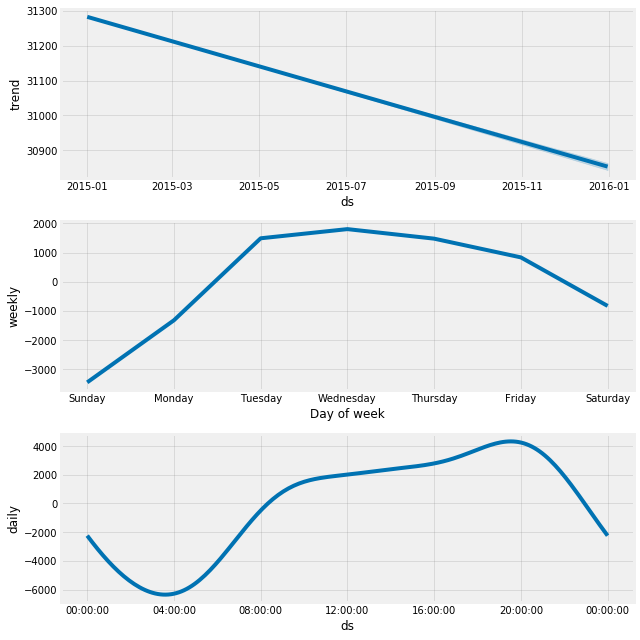

In [69]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst)

## Predict With Holidays

In [70]:
# Predict on training set with model
pjme_test_fcst_with_hols = model_with_holidays.predict( pjme_test )

In [71]:
pjme_test_fcst_with_hols.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,32979.674823,27541.652668,35735.764998,32979.674823,32979.674823,-1422.619542,-1422.619542,-1422.619542,-2244.252483,...,-652.926002,-652.926002,-652.926002,1474.558943,1474.558943,1474.558943,0.0,0.0,0.0,31557.055281
1,2015-01-01 01:00:00,32982.770129,25415.835878,33713.552032,32982.770129,32982.770129,-3281.232684,-3281.232684,-3281.232684,-4075.414830,...,-652.926002,-652.926002,-652.926002,1447.108148,1447.108148,1447.108148,0.0,0.0,0.0,29701.537446
2,2015-01-01 02:00:00,32985.865436,24099.597953,32746.821055,32985.865436,32985.865436,-4672.422554,-4672.422554,-4672.422554,-5438.602559,...,-652.926002,-652.926002,-652.926002,1419.106007,1419.106007,1419.106007,0.0,0.0,0.0,28313.442882
3,2015-01-01 03:00:00,32988.960742,23468.452461,31670.525969,32988.960742,32988.960742,-5479.729632,-5479.729632,-5479.729632,-6217.490495,...,-652.926002,-652.926002,-652.926002,1390.686865,1390.686865,1390.686865,0.0,0.0,0.0,27509.231110
4,2015-01-01 04:00:00,32992.056048,23446.535557,31587.002865,32992.056048,32992.056048,-5577.822103,-5577.822103,-5577.822103,-6286.882035,...,-652.926002,-652.926002,-652.926002,1361.985934,1361.985934,1361.985934,0.0,0.0,0.0,27414.233945


In [72]:
mean_absolute_percentage_error(y_true=pjme_test['y'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

50.31281229285918